In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ptitprince as pt
import inspect
from scipy.stats import t

In [3]:
shared_control_ssrt = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_ssrt.csv")
simple_stop_ssrt = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/simple_stop_metrics.csv")
participant_tracking = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/participant_tracking.csv')
survey_results = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/survey_scores.csv')
go_task_accuracy_before_stop_onset = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_go_task_accuracy_before_stop_onset.csv')
go_task_accuracy_after_stop_onset = pd.read_csv('/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_go_task_accuracy_after_stop_onset.csv')
duration_of_inhibition = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_metrics_duration_of_inhibition.csv")
proportion_of_trials_with_stop_moment = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/proportion_of_trials_with_stop_moment.csv")
ssrt_first_half = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_ssrt_first_half.csv")
ssrt_second_half = pd.read_csv("/Users/kritiaxh/Documents/PoldrackLab/SharedControl/notebooks/analysis/output/shared_control_ssrt_second_half.csv")

In [4]:
# Set the first column as the index to use for merging (assuming it's the subject ID)
shared_control_ssrt.columns = ['subject_id'] + list(shared_control_ssrt.columns[1:])
simple_stop_ssrt.columns = ['subject_id'] + list(simple_stop_ssrt.columns[1:])

# Merge by the first (subject_id) column
merged_df = pd.merge(shared_control_ssrt, simple_stop_ssrt[['subject_id', 'ssrt']], on='subject_id', how='left')

# Rename columns
merged_df.rename(columns={'ssrt': 'simple_stop_ssrt', 'ai_ssrt': 'ai_disengaged_ssrt', 'ai_ai_ssrt': 'ai_engaged_ssrt'}, inplace=True)

In [5]:
# Remove the last row, assuming it's the mean row
merged_df = merged_df.iloc[:-1, :]
go_task_accuracy_before_stop_onset = go_task_accuracy_before_stop_onset.iloc[:-1, :]
go_task_accuracy_after_stop_onset = go_task_accuracy_after_stop_onset.iloc[:-1, :]
duration_of_inhibition = duration_of_inhibition.iloc[:-1, :]
proportion_of_trials_with_stop_moment = proportion_of_trials_with_stop_moment.iloc[:-1, :]
ssrt_first_half = ssrt_first_half.iloc[:-1, :]
ssrt_second_half = ssrt_second_half.iloc[:-1, :]

## Stats Functions

In [6]:
def cohens_d_paired(x1, x2):
    """Calculate Cohen's d for paired samples"""
    d = (x1 - x2).mean() / np.sqrt(((x1 - x2).std(ddof=1) ** 2) / 2)
    return d

# Calculate mean difference and confidence intervals for SSRT differences
def calculate_ci_for_difference(x1, x2, confidence=0.95):
    """Calculate confidence interval for the mean difference between two paired samples"""
    diff = x1 - x2
    n = len(diff)
    mean_diff = np.mean(diff)
    sem = stats.sem(diff)  # Standard error of the mean
    ci = stats.t.interval(confidence, n-1, loc=mean_diff, scale=sem)
    return mean_diff, ci

In [7]:
def calc_stats_ind(x1, x2):
    """Calculate Cohen's d, DF, 95% CI for two independent samples"""
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(x1, x2, nan_policy='omit')
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

    # Calculate Cohen's d
    mean_x1 = np.mean(x1)
    mean_x2 = np.mean(x2)
    std_x1 = np.std(x1, ddof=1)  # Sample standard deviation
    std_x2 = np.std(x2, ddof=1)

    # Pooled standard deviation
    n1 = len(x1)
    n2 = len(x2)
    pooled_std = np.sqrt(((n1 - 1) * std_x1**2 + (n2 - 1) * std_x2**2) / (n1 + n2 - 2))

    # Cohen's d
    cohens_d = (mean_x1 - mean_x2) / pooled_std
    print(f"Cohen's d: {cohens_d:.3f}")

    # Degrees of freedom
    degrees_of_freedom = n1 + n2 - 2
    print(f"Degrees of Freedom: {degrees_of_freedom}")

    # Confidence Interval Calculation
    mean_diff = mean_x1 - mean_x2
    se_diff = np.sqrt((std_x1**2 / n1) + (std_x2**2 / n2))

    # 95% CI
    ci = stats.t.interval(0.95, df=degrees_of_freedom, loc=mean_diff, scale=se_diff)
    print(f"95% CI for mean difference: [{ci[0]:.3f}, {ci[1]:.3f}]")

In [8]:
def calc_ci_for_individual_metrics(df):
    """ Calculate means and confidence intervals for individual metrics such as Non-AI SSRT"""
    third_column_name = df.columns[2]  # Get the name of the third column (index 2)

    # Group by 'Condition' and compute Mean and SEM for the third column
    means_df = df.groupby('Condition').agg(
        Mean=(third_column_name, 'mean'),
        SEM=(third_column_name, stats.sem)  # Standard error of the mean for this column
    ).reset_index()

    # Ensure correct ordering in means_df
    means_df['Condition'] = pd.Categorical(means_df['Condition'], ordered=True)
    means_df = means_df.sort_values('Condition')

    # Calculate the degrees of freedom
    n = df.shape[0]  # Total number of samples
    df = n - 1  # Degrees of freedom

    # Calculate the confidence intervals
    confidence_level = 0.95
    ci_bounds = stats.t.interval(confidence_level, df, loc=means_df['Mean'], scale=means_df['SEM'])
    means_df['CI_lower'] = ci_bounds[0]
    means_df['CI_upper'] = ci_bounds[1]

    # Print means_df to check the order
    print("Means DataFrame:")
    print(means_df)

## Planned Statistical Tests

In [9]:
# Reshape the data for repeated measures ANOVA
data_long = pd.melt(merged_df, id_vars=['subject_id'], value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt', 'simple_stop_ssrt'],
                    var_name='condition', value_name='SSRT')


# Run the repeated measures ANOVA
aovrm = AnovaRM(data_long, 'SSRT', 'subject_id', within=['condition'])
anova_results = aovrm.fit()

In [10]:
# Conduct the paired t-tests for planned comparisons

# Comparison 1: AI Stop vs non-AI Stop
ai_vs_non_ai = stats.ttest_rel(merged_df['ai_disengaged_ssrt'], merged_df['non_ai_ssrt'])
print(f"AI Disengaged vs Non-AI SSRT Comparison: t-statistic = {ai_vs_non_ai.statistic}, p-value = {ai_vs_non_ai.pvalue}")

# Comparison 2: Non-AI vs Simple Stopping
non_ai_vs_simple = stats.ttest_rel(merged_df['non_ai_ssrt'], merged_df['simple_stop_ssrt'])
non_ai_vs_simple_corr = np.corrcoef(merged_df['non_ai_ssrt'], merged_df['simple_stop_ssrt'])[1][0]
print(f"Non-AI vs Simple Stopping SSRT Comparison: t-statistic = {non_ai_vs_simple.statistic}, p-value = {non_ai_vs_simple.pvalue}")
print(non_ai_vs_simple_corr)

AI Disengaged vs Non-AI SSRT Comparison: t-statistic = 5.829069557315186, p-value = 8.947284304246281e-07
Non-AI vs Simple Stopping SSRT Comparison: t-statistic = 13.335317900235957, p-value = 4.1284915082684623e-16
0.5303411888448846


In [11]:
# Find cohen's d, mean difference, and 95% CI
# Comparison 1: AI Stop vs non-AI Stop
cohens_d1 = cohens_d_paired(merged_df['ai_disengaged_ssrt']*1000, merged_df['non_ai_ssrt']*1000)
mean_diff1, ci1 = calculate_ci_for_difference(merged_df['ai_disengaged_ssrt']*1000, merged_df['non_ai_ssrt']*1000)
print("\nAI Disengaged vs Non-AI SSRT:")
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

# Comparison 2: Non-AI vs Simple Stopping
cohens_d2 = cohens_d_paired(merged_df['non_ai_ssrt']*1000, merged_df['simple_stop_ssrt']*1000)
mean_diff2, ci2 = calculate_ci_for_difference(merged_df['non_ai_ssrt']*1000, merged_df['simple_stop_ssrt']*1000)
print("\nNon-AI vs Simple Stopping SSRT:")
print(f"Cohen's d: {cohens_d2:.3f}")
print(f"Mean difference = {mean_diff2:.3f} ms")
print(f"95% CI: [{ci2[0]:.3f}, {ci2[1]:.3f}] ms")


AI Disengaged vs Non-AI SSRT:
Cohen's d: 1.303
Mean difference = 22.715 ms
95% CI: [14.833, 30.597] ms

Non-AI vs Simple Stopping SSRT:
Cohen's d: 2.982
Mean difference = 60.615 ms
95% CI: [51.421, 69.809] ms


## Create Tables for the Paper

In [12]:
# Calculate means and standard deviations before and after stop onset
mean_values = go_task_accuracy_before_stop_onset[['non_ai_go_task_accuracy_before_stop_onset', 
                                                   'ai_go_task_accuracy_before_stop_onset', 
                                                   'ai_ai_go_task_accuracy_before_stop_onset']].mean()
sd_values = go_task_accuracy_before_stop_onset[['non_ai_go_task_accuracy_before_stop_onset', 
                                                'ai_go_task_accuracy_before_stop_onset', 
                                                'ai_ai_go_task_accuracy_before_stop_onset']].std()
mean_values_after = go_task_accuracy_after_stop_onset[['non_ai_go_task_accuracy_after_stop_onset', 
                                                       'ai_go_task_accuracy_after_stop_onset', 
                                                       'ai_ai_go_task_accuracy_after_stop_onset']].mean()
sd_values_after = go_task_accuracy_after_stop_onset[['non_ai_go_task_accuracy_after_stop_onset', 
                                                      'ai_go_task_accuracy_after_stop_onset', 
                                                      'ai_ai_go_task_accuracy_after_stop_onset']].std()

# Combine into a single DataFrame with formatted means and SDs in brackets
metrics_mean_sd = pd.DataFrame({
    'Non-AI': [
        f"{round(mean_values['non_ai_go_task_accuracy_before_stop_onset'], 2)} ({round(sd_values['non_ai_go_task_accuracy_before_stop_onset'], 2)})",
        f"{round(mean_values_after['non_ai_go_task_accuracy_after_stop_onset'], 2)} ({round(sd_values_after['non_ai_go_task_accuracy_after_stop_onset'], 2)})",
        f"{round(merged_df['non_ai_ssrt'].mean() * 1000, 2)} ms ({round(merged_df['non_ai_ssrt'].std() * 1000, 2)} ms)"
    ],
    'AI-disengaged': [
        f"{round(mean_values['ai_go_task_accuracy_before_stop_onset'], 2)} ({round(sd_values['ai_go_task_accuracy_before_stop_onset'], 2)})",
        f"{round(mean_values_after['ai_go_task_accuracy_after_stop_onset'], 2)} ({round(sd_values_after['ai_go_task_accuracy_after_stop_onset'], 2)})",
        f"{round(merged_df['ai_disengaged_ssrt'].mean() * 1000, 2)} ms ({round(merged_df['ai_disengaged_ssrt'].std() * 1000, 2)} ms)"
    ],
    'AI-engaged': [
        f"{round(mean_values['ai_ai_go_task_accuracy_before_stop_onset'], 2)} ({round(sd_values['ai_ai_go_task_accuracy_before_stop_onset'], 2)})",
        f"{round(mean_values_after['ai_ai_go_task_accuracy_after_stop_onset'], 2)} ({round(sd_values_after['ai_ai_go_task_accuracy_after_stop_onset'], 2)})",
        f"{round(merged_df['ai_engaged_ssrt'].mean() * 1000, 2)} ms ({round(merged_df['ai_engaged_ssrt'].std() * 1000, 2)} ms)"
    ]
}, index=[
    'Mean of Go Task Accuracy Before Stop Onset',
    'Mean of Stop Success Rate',
    'Mean of SSRT (ms)'
])

# Print the DataFrame
print(metrics_mean_sd)

# Save to CSV
metrics_mean_sd.to_csv('output/shared_control_metrics_mean_sd.csv')

                                                          Non-AI  \
Mean of Go Task Accuracy Before Stop Onset           0.87 (0.08)   
Mean of Stop Success Rate                            0.59 (0.16)   
Mean of SSRT (ms)                           276.17 ms (27.88 ms)   

                                                   AI-disengaged  \
Mean of Go Task Accuracy Before Stop Onset            0.9 (0.08)   
Mean of Stop Success Rate                             0.4 (0.17)   
Mean of SSRT (ms)                           298.88 ms (34.77 ms)   

                                                      AI-engaged  
Mean of Go Task Accuracy Before Stop Onset            0.9 (0.05)  
Mean of Stop Success Rate                            0.92 (0.04)  
Mean of SSRT (ms)                           331.03 ms (61.91 ms)  


OSError: Cannot save file into a non-existent directory: 'output'

## Order Effects

In [ ]:
# Calculate order effects between AI being first or Non-AI being first
non_ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 1]["Subject"].to_list()
ai_first_subs = participant_tracking[participant_tracking["Cond Order"] == 2]["Subject"].to_list()

ssrt_non_ai_first_non_ai = []
ssrt_ai_first_non_ai = []
ssrt_non_ai_first_ai = []
ssrt_ai_first_ai = []
ssrt_non_ai_first_ai_ai = []
ssrt_ai_first_ai_ai = []

for sub in non_ai_first_subs:
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["non_ai_ssrt"].values
    ssrt_non_ai_first_non_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ssrt"].values
    ssrt_non_ai_first_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ai_ssrt"].values
    ssrt_non_ai_first_ai_ai.append(ssrt[0])

for sub in ai_first_subs:
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["non_ai_ssrt"].values
    ssrt_ai_first_non_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ssrt"].values
    ssrt_ai_first_ai.append(ssrt[0])
    ssrt = shared_control_ssrt[shared_control_ssrt['subject_id'] == sub]["ai_ai_ssrt"].values
    ssrt_ai_first_ai_ai.append(ssrt[0])

t_stat, p_value = stats.ttest_ind(ssrt_ai_first_non_ai, ssrt_non_ai_first_non_ai, equal_var=False)
print(f'Comparison of Non-AI SSRT between AI-first and Non-AI-first groups: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}')

t_stat, p_value = stats.ttest_ind(ssrt_ai_first_ai, ssrt_non_ai_first_ai, equal_var=False)
print(f'Comparison of AI SSRT between AI-first and Non-AI-first groups: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}')

t_stat, p_value = stats.ttest_ind(ssrt_ai_first_ai_ai, ssrt_non_ai_first_ai_ai, equal_var=False)
print(f'Comparison of AI AI SSRT between AI-first and Non-AI-first groups: t-statistic = {t_stat:.3f}, p-value = {p_value:.4f}')
# Calculate the differences between AI SSRT and Non-AI SSRT for both subject groups
diff_non_ai_first = np.array(ssrt_non_ai_first_ai) - np.array(ssrt_non_ai_first_non_ai)  # AI - Non-AI for Non-AI first subjects
diff_ai_first = np.array(ssrt_ai_first_ai) - np.array(ssrt_ai_first_non_ai)  # AI - Non-AI for AI first subjects
print()
print(f'AI - Non-AI difference between groups:')

calc_stats_ind(diff_ai_first, diff_non_ai_first)

#Calculate means and confidence intervals
mean_ai_first = diff_ai_first.mean()
mean_non_ai_first = diff_non_ai_first.mean()

ci_ai_first = stats.t.interval(.95, len(diff_ai_first)-1, loc=mean_ai_first, scale=stats.sem(diff_ai_first))
print(f"Mean difference (AI first): {mean_ai_first:.2f} ms, 95% CI: [{ci_ai_first[0]:.2f}, {ci_ai_first[1]:.2f}] ms")

ci_non_ai_first = stats.t.interval(.95, len(diff_non_ai_first)-1, loc=mean_non_ai_first, scale=stats.sem(diff_non_ai_first))
print(f"Mean difference (Non-AI first): {mean_non_ai_first:.2f} ms, 95% CI: [{ci_non_ai_first[0]:.2f}, {ci_non_ai_first[1]:.2f}] ms")


Comparison of Non-AI SSRT between AI-first and Non-AI-first groups: t-statistic = 0.648, p-value = 0.5211
Comparison of AI SSRT between AI-first and Non-AI-first groups: t-statistic = 1.266, p-value = 0.2134
Comparison of AI AI SSRT between AI-first and Non-AI-first groups: t-statistic = -0.138, p-value = 0.8910

AI - Non-AI difference between groups:
T-statistic: 1.04, P-value: 0.3071
Cohen's d: 0.327
Degrees of Freedom: 38
95% CI for mean difference: [-0.008, 0.024]
Mean difference (AI first): 0.03 ms, 95% CI: [0.01, 0.04] ms
Mean difference (Non-AI first): 0.02 ms, 95% CI: [0.01, 0.03] ms


In [ ]:
# T test for AI vs Non AI SSRT in the first half of trials
ai_vs_non_ai = stats.ttest_rel(ssrt_first_half['ai_ssrt_first_half'], ssrt_first_half['non_ai_ssrt_first_half'])
print(f"AI Disengaged vs Non-AI SSRT Comparison in the first half of trials: t-statistic = {ai_vs_non_ai.statistic:.3f}, p-value = {ai_vs_non_ai.pvalue:.4f}")

cohens_d1 = cohens_d_paired(ssrt_first_half['ai_ssrt_first_half']*1000, ssrt_first_half['non_ai_ssrt_first_half']*1000)
mean_diff1, ci1 = calculate_ci_for_difference(ssrt_first_half['ai_ssrt_first_half']*1000, ssrt_first_half['non_ai_ssrt_first_half']*1000)
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

ssrt_first_half.columns = ['subject_id'] + list(ssrt_first_half.columns[1:])

melted_df_first_half_ssrt = ssrt_first_half.melt(id_vars='subject_id', value_vars=['non_ai_ssrt_first_half', 'ai_ssrt_first_half'],
                            var_name='Condition', value_name='SSRT')
melted_df_first_half_ssrt['SSRT']*=1000

calc_ci_for_individual_metrics(melted_df_first_half_ssrt)

AI Disengaged vs Non-AI SSRT Comparison in the first half of trials: t-statistic = 3.283, p-value = 0.0022
Cohen's d: 0.734
Mean difference = 21.405 ms
95% CI: [8.217, 34.594] ms
Means DataFrame:
                Condition        Mean       SEM    CI_lower    CI_upper
0      ai_ssrt_first_half  295.269382  7.423677  280.492922  310.045843
1  non_ai_ssrt_first_half  273.863893  4.369819  265.165985  282.561801


In [ ]:
# T test for AI vs Non AI SSRT in the second half of all trials
ai_vs_non_ai = stats.ttest_rel(ssrt_second_half['ai_ssrt_second_half'], ssrt_second_half['non_ai_ssrt_second_half'])
print(f"AI Disengaged vs Non-AI SSRT Comparison in the second half of trials: t-statistic = {ai_vs_non_ai.statistic:.3f}, p-value = {ai_vs_non_ai.pvalue:.4f}")

cohens_d1 = cohens_d_paired(ssrt_second_half['ai_ssrt_second_half']*1000, ssrt_second_half['non_ai_ssrt_second_half']*1000)
mean_diff1, ci1 = calculate_ci_for_difference(ssrt_second_half['ai_ssrt_second_half']*1000, ssrt_second_half['non_ai_ssrt_second_half']*1000)
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

ssrt_second_half.columns = ['subject_id'] + list(ssrt_second_half.columns[1:])

melted_df_second_half_ssrt = ssrt_second_half.melt(id_vars='subject_id', value_vars=['non_ai_ssrt_second_half', 'ai_ssrt_second_half'],
                            var_name='Condition', value_name='SSRT')
melted_df_second_half_ssrt['SSRT']*=1000

calc_ci_for_individual_metrics(melted_df_second_half_ssrt)

AI Disengaged vs Non-AI SSRT Comparison in the second half of trials: t-statistic = 4.820, p-value = 0.0000
Cohen's d: 1.078
Mean difference = 25.485 ms
95% CI: [14.791, 36.180] ms
Means DataFrame:
                 Condition        Mean       SEM    CI_lower    CI_upper
0      ai_ssrt_second_half  303.959558  6.096214  291.825347  316.093769
1  non_ai_ssrt_second_half  278.474436  5.025271  268.471885  288.476987


## Create main plots for the paper

/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


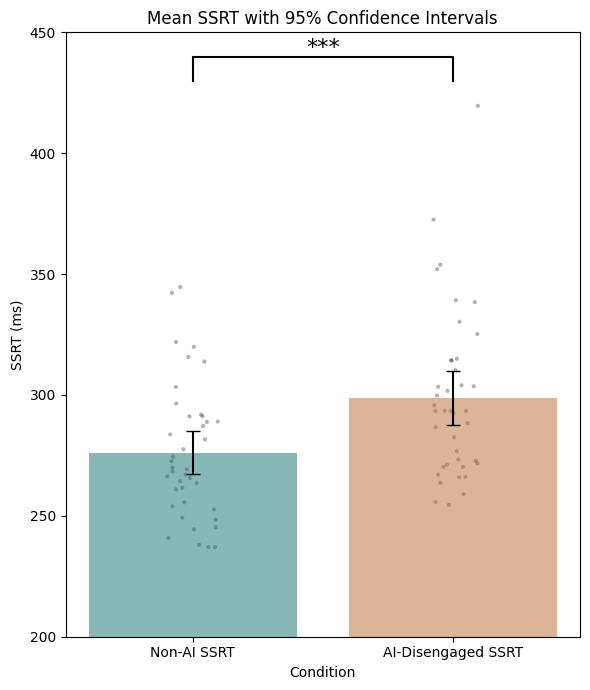

In [ ]:
# Assuming merged_df is already defined and contains the necessary data
# Melting the DataFrame
melted_df_ssrt = merged_df.melt(id_vars='subject_id', value_vars=['non_ai_ssrt', 'ai_disengaged_ssrt'],
                            var_name='Condition', value_name='SSRT')
melted_df_ssrt['SSRT'] *= 1000  # Convert to milliseconds

# Define custom names for the conditions
custom_names = {
    'non_ai_ssrt': 'Non-AI SSRT',
    'ai_disengaged_ssrt': 'AI-Disengaged SSRT'
}

# Replace the original condition names with custom names
melted_df_ssrt['Condition'] = melted_df_ssrt['Condition'].map(custom_names)

# Step 1: Calculate means and confidence intervals for the conditions
summary_df = melted_df_ssrt.groupby('Condition').agg(
    Mean=('SSRT', 'mean'),
    SEM=('SSRT', stats.sem)  # Standard error of the mean
).reset_index()

# Calculate degrees of freedom for confidence intervals
n = melted_df_ssrt.groupby('Condition').size()  # Count of samples per condition
df = n - 1  # Degrees of freedom

# Calculate 95% confidence intervals
ci_bounds = stats.t.interval(0.95, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

# Step 2: Create bar plots with confidence intervals
summary_df = melted_df_ssrt.groupby('Condition').agg(
    Mean=('SSRT', 'mean'),
    SEM=('SSRT', stats.sem)  # Standard error of the mean
).reset_index()

# Calculate degrees of freedom
n = melted_df_ssrt.groupby('Condition').size()  # Count of samples per condition
df = n - 1  # Degrees of freedom for CI
confidence_level = 0.95

# Calculate 95% CI
ci_bounds = stats.t.interval(confidence_level, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

desired_order = ['Non-AI SSRT', 'AI-Disengaged SSRT']  # Explicit order

# Set the 'Condition' column to a categorical type with the specified order
summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories=desired_order, ordered=True)
summary_df = summary_df.sort_values('Condition').reset_index()

# Create the figure and adjust the bar plot
plt.figure(figsize=(6, 7))

sns.barplot(data=summary_df, x='Condition', y='Mean', palette=["teal", "chocolate"], alpha=0.5)

# Overlay strip plot (individual data points) with transparency
sns.stripplot(x='Condition', y='SSRT', data=melted_df_ssrt, color='black', alpha=0.3, size=3, jitter=1, zorder=0)

# Add custom error bars for confidence intervals
for index, row in summary_df.iterrows():
    plt.errorbar(x=index, y=row['Mean'], 
                 yerr=[[row['Mean'] - row['CI_lower']], [row['CI_upper'] - row['Mean']]], 
                 fmt='none', color='black', capsize=5)
    
plt.plot([0, 0, 1, 1], [430, 440, 440, 430], color='black')
    
# Determine asterisk placement
plt.text(0.5, 441, "***", ha='center', fontsize=16)

# Set the title and labels
plt.title('Mean SSRT with 95% Confidence Intervals')
plt.ylim((200, 450))
plt.xlabel('Condition')
plt.ylabel('SSRT (ms)')

# Finalize layout and show the plot
plt.tight_layout()
plt.savefig('figures/mean_ssrt_with_ci_barplot.png', dpi=300) 
plt.show()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/lib/python3.12/site

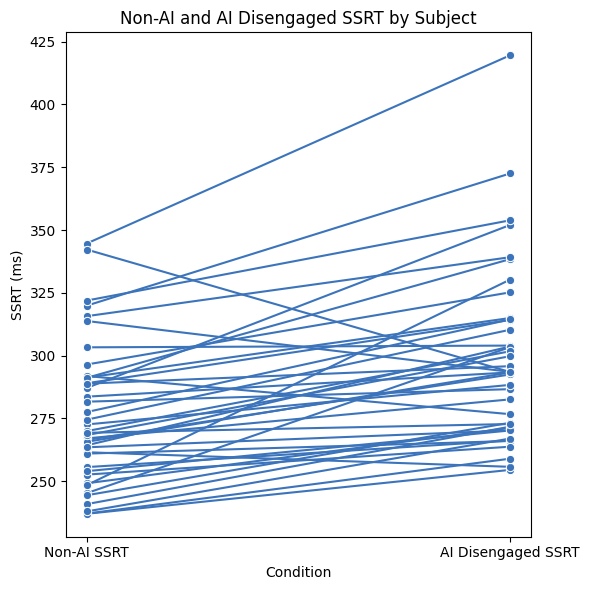

In [ ]:
# Create the line plot
plt.figure(figsize=(6, 6))
ax = sns.lineplot(x='Condition', y='SSRT', data=melted_df_ssrt, hue='subject_id', 
                  marker='o', palette=['#3C74BC'] * len(melted_df_ssrt['subject_id'].unique()), legend=False)

# Manually change the condition names in the x-axis labels
ax.set_xticklabels(['Non-AI SSRT', 'AI Disengaged SSRT'])

# Set the title and labels
ax.set_title('Non-AI and AI Disengaged SSRT by Subject')
ax.set_ylabel('SSRT (ms)')

# Finalize layout and save the plot
plt.tight_layout()
plt.savefig('figures/non_ai_and_ai_disengaged_ssrt_by_subject.png', dpi=300)
plt.show()

In [ ]:
duration_of_inhibition.columns = ['subject_id'] + list(duration_of_inhibition.columns[1:])

melted_df_duration = duration_of_inhibition.melt(id_vars='subject_id', value_vars=['non_ai_duration_of_inhibition', 'ai_duration_of_inhibition'],
                            var_name='Condition', value_name='Duration of Inhibition')

melted_df_duration['Duration of Inhibition'] *= 1000  # Convert to milliseconds

custom_names = {
    'non_ai_duration_of_inhibition': 'Non-AI',
    'ai_duration_of_inhibition': 'AI-Disengaged'
}

melted_df_duration['Condition'] = melted_df_duration['Condition'].map(custom_names)

# Step 1: Calculate means and confidence intervals for the conditions
summary_df = melted_df_duration.groupby('Condition').agg(
    Mean=('Duration of Inhibition', 'mean'),
    SEM=('Duration of Inhibition', stats.sem)  # Standard error of the mean
).reset_index()

# Calculate degrees of freedom for confidence intervals
n = melted_df_duration.groupby('Condition').size()  # Count of samples per condition
df = n - 1  # Degrees of freedom

# Calculate 95% confidence intervals
ci_bounds = stats.t.interval(0.95, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

# Step 2: Create bar plots with confidence intervals
summary_df = melted_df_duration.groupby('Condition').agg(
    Mean=('Duration of Inhibition', 'mean'),
    SEM=('Duration of Inhibition', stats.sem)  # Standard error of the mean
).reset_index()

# Calculate degrees of freedom
n = melted_df_duration.groupby('Condition').size()  # Count of samples per condition
df = n - 1  # Degrees of freedom for CI
confidence_level = 0.95

# Calculate 95% CI
ci_bounds = stats.t.interval(confidence_level, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

desired_order = ['Non-AI', 'AI-Disengaged']  # Explicit order

# Set the 'Condition' column to a categorical type with the specified order
summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories=desired_order, ordered=True)
summary_df = summary_df.sort_values('Condition').reset_index()

# Create the figure and adjust the bar plot
plt.figure(figsize=(6, 7))

sns.barplot(data=summary_df, x='Condition', y='Mean', palette=["teal", "chocolate"], alpha=0.5)

# Overlay strip plot (individual data points) with transparency
sns.stripplot(x='Condition', y='Duration of Inhibition', data=melted_df_duration, color='black', alpha=0.3, size=3, jitter=1, zorder=0)

# Add custom error bars for confidence intervals
for index, row in summary_df.iterrows():
    plt.errorbar(x=index, y=row['Mean'], 
                 yerr=[[row['Mean'] - row['CI_lower']], [row['CI_upper'] - row['Mean']]], 
                 fmt='none', color='black', capsize=5)
    
plt.plot([0, 0, 1, 1], [110, 115, 115, 110], color='black')
    
# Determine asterisk placement
plt.text(0.5, 116, "***", ha='center', fontsize=16)

# Set the title and labels
plt.ylim((0, 120))
plt.xlabel('Condition')
plt.ylabel('Duration of Inhibition (ms)')

# Finalize layout and show the plot
plt.tight_layout()
plt.savefig('figures/mean_duration_with_ci_barplot.png', dpi=300) 
plt.show()

NameError: name 'duration_of_inhibition' is not defined

## Exploratory T-tests and Confidence Intervals

In [ ]:
# Calculate CIs for SSRT
calc_ci_for_individual_metrics(melted_df_ssrt)

Means DataFrame:
            Condition        Mean       SEM    CI_lower    CI_upper
0  AI-Disengaged SSRT  298.884440  5.497932  287.941081  309.827800
1         Non-AI SSRT  276.169311  4.407977  267.395452  284.943171


In [ ]:
# T test for AI vs Non AI Duration of inhibition
t_stat, p_value = stats.ttest_rel(duration_of_inhibition['ai_duration_of_inhibition'], duration_of_inhibition['non_ai_duration_of_inhibition'])
# Print the t-statistic and p-value
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

cohens_d1 = cohens_d_paired(duration_of_inhibition['ai_duration_of_inhibition'], duration_of_inhibition['non_ai_duration_of_inhibition'])
mean_diff1, ci1 = calculate_ci_for_difference(duration_of_inhibition['ai_duration_of_inhibition'], duration_of_inhibition['non_ai_duration_of_inhibition'])
print("\nAI-Disengaged vs Non AI Duration of inhibition")
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")
calc_ci_for_individual_metrics(melted_df_duration)

T-statistic: 2.692, P-value: 0.0104

AI-Disengaged vs Non AI Duration of inhibition
Cohen's d: 0.602
Mean difference = 0.006 ms
95% CI: [0.001, 0.010] ms
Means DataFrame:
                              Condition       Mean       SEM   CI_lower  \
0  AI-Disengaged Duration of Inhibition  47.237714  2.714099  41.835435   
1         Non-AI Duration of Inhibition  41.473964  1.603309  38.282657   

    CI_upper  
0  52.639992  
1  44.665270  


In [ ]:
melted_df_simple_stop_ssrt = merged_df.melt(id_vars='subject_id', value_vars=['non_ai_ssrt', 'simple_stop_ssrt'],
                            var_name='Condition', value_name='SSRT')
melted_df_simple_stop_ssrt['SSRT']*=1000

calc_ci_for_individual_metrics(melted_df_simple_stop_ssrt)

Means DataFrame:
          Condition        Mean       SEM    CI_lower    CI_upper
0       non_ai_ssrt  276.169311  4.407977  267.395452  284.943171
1  simple_stop_ssrt  215.554210  4.925375  205.750496  225.357924


In [ ]:
mean_non_ai = go_task_accuracy_before_stop_onset['non_ai'].mean()
mean_ai_disengaged = go_task_accuracy_before_stop_onset['ai_disengaged'].mean()

print(f"Mean Non-AI Accuracy: {mean_non_ai:.2f}")
print(f"Mean AI Disengaged Accuracy: {mean_ai_disengaged:.2f}")

# T test for AI vs Non AI Go task accuracy before stop onset
t_stat, p_value = stats.ttest_rel(go_task_accuracy_before_stop_onset['ai_disengaged'], go_task_accuracy_before_stop_onset['non_ai'])

# Print the t-statistic and p-value
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}")

cohens_d1 = cohens_d_paired(go_task_accuracy_before_stop_onset['ai_disengaged'], go_task_accuracy_before_stop_onset['non_ai'])
mean_diff1, ci1 = calculate_ci_for_difference(go_task_accuracy_before_stop_onset['ai_disengaged'], go_task_accuracy_before_stop_onset['non_ai'])
print(f"Cohen's d: {cohens_d1:.2f}")
print(f"Mean difference = {mean_diff1:.2f} ms")
print(f"95% CI: [{ci1[0]:.2f}, {ci1[1]:.2f}] ms")

melted_df_go_task_accuracy = go_task_accuracy_before_stop_onset.melt(id_vars='subject_id', value_vars=['non_ai', 'ai_disengaged'],
                            var_name='Condition', value_name='Go Task Accuracy Before Stop Onset')

calc_ci_for_individual_metrics(melted_df_go_task_accuracy)

Mean Non-AI Accuracy: 0.87
Mean AI Disengaged Accuracy: 0.90
T-statistic: 2.81, P-value: 0.008
Cohen's d: 0.63
Mean difference = 0.03 ms
95% CI: [0.01, 0.06] ms
Means DataFrame:
       Condition      Mean       SEM  CI_lower  CI_upper
0  ai_disengaged  0.900721  0.012925  0.874995  0.926447
1         non_ai  0.866798  0.013170  0.840585  0.893011


In [ ]:
# T-test for go task accuracy after stop onset (aka stop success rate)
mean_non_ai = go_task_accuracy_after_stop_onset['non_ai_go_task_accuracy_after_stop_onset'].mean()
mean_ai_disengaged = go_task_accuracy_after_stop_onset['ai_go_task_accuracy_after_stop_onset'].mean()

print(f"Mean Non-AI Accuracy: {mean_non_ai:.2f}")
print(f"Mean AI Disengaged Accuracy: {mean_ai_disengaged:.2f}")

# T test for AI vs Non AI Go task accuracy before stop onset
t_stat, p_value = stats.ttest_rel(go_task_accuracy_after_stop_onset['ai_go_task_accuracy_after_stop_onset'], go_task_accuracy_after_stop_onset['non_ai_go_task_accuracy_after_stop_onset'])

# Print the t-statistic and p-value
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}")

cohens_d1 = cohens_d_paired(go_task_accuracy_after_stop_onset['ai_go_task_accuracy_after_stop_onset'], go_task_accuracy_after_stop_onset['non_ai_go_task_accuracy_after_stop_onset'])
mean_diff1, ci1 = calculate_ci_for_difference(go_task_accuracy_after_stop_onset['ai_go_task_accuracy_after_stop_onset'], go_task_accuracy_after_stop_onset['non_ai_go_task_accuracy_after_stop_onset'])
print(f"Cohen's d: {cohens_d1:.2f}")
print(f"Mean difference = {mean_diff1:.2f} ms")
print(f"95% CI: [{ci1[0]:.2f}, {ci1[1]:.2f}] ms")

Mean Non-AI Accuracy: 0.59
Mean AI Disengaged Accuracy: 0.40
T-statistic: -8.88, P-value: 0.000
Cohen's d: -1.98
Mean difference = -0.19 ms
95% CI: [-0.24, -0.15] ms


In [ ]:
# T-test for difference in Non AI and AI SSRT in subjects who didn't show proactive slowing
non_proactive_slowing_data['ssrt_ai_disengaged']*=1000
non_proactive_slowing_data['ssrt_non_ai']*=1000
t_stat, p_value = stats.ttest_rel(non_proactive_slowing_data['ssrt_ai_disengaged'], non_proactive_slowing_data['ssrt_non_ai'])
print(len(non_proactive_slowing_data))
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")

cohens_d1 = cohens_d_paired(non_proactive_slowing_data['ssrt_ai_disengaged'], non_proactive_slowing_data['ssrt_non_ai'])
mean_diff1, ci1 = calculate_ci_for_difference(non_proactive_slowing_data['ssrt_ai_disengaged'], non_proactive_slowing_data['ssrt_non_ai'])
print("\nDifference in Non AI and AI SSRT in subjects who didn't show proactive slowing")
print(f"Cohen's d: {cohens_d1:.3f}")
print(f"Mean difference = {mean_diff1:.3f} ms")
print(f"95% CI: [{ci1[0]:.3f}, {ci1[1]:.3f}] ms")

melted_df_non_proactive_slowing = non_proactive_slowing_data.melt(id_vars='subject_id', value_vars=['ssrt_non_ai', 'ssrt_ai_disengaged'],
                            var_name='Condition', value_name='SSRT ')
calc_ci_for_individual_metrics(melted_df_non_proactive_slowing)



10
T-statistic: 2.936, P-value: 0.0166

Difference in Non AI and AI SSRT in subjects who didn't show proactive slowing
Cohen's d: 1.313
Mean difference = 30.018 ms
95% CI: [6.893, 53.142] ms
Means DataFrame:
            Condition        Mean        SEM    CI_lower    CI_upper
0  ssrt_ai_disengaged  297.705859  15.510576  265.241850  330.169868
1         ssrt_non_ai  267.688122  10.017141  246.722004  288.654239


/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_18897/2660384337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_proactive_slowing_data['ssrt_ai_disengaged']*=1000
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_18897/2660384337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_proactive_slowing_data['ssrt_non_ai']*=1000


In [ ]:
non_proactive_differences = plot_data[plot_data['slowing_type'] == 'Non-Proactive']['difference_ms'].dropna()
proactive_differences = plot_data[plot_data['slowing_type'] == 'Proactive']['difference_ms'].dropna()

calc_stats_ind(non_proactive_differences, proactive_differences)
# Print the means
# Calculate the mean difference for each group
mean_non_proactive = plot_data[plot_data['slowing_type'] == 'Non-Proactive']['difference_ms'].mean()
mean_proactive = plot_data[plot_data['slowing_type'] == 'Proactive']['difference_ms'].mean()

ci_non_proactive = stats.t.interval(.95, len(non_proactive_differences)-1, loc=mean_non_proactive, scale=stats.sem(non_proactive_differences))
print(f"Mean difference (Non-Proactive): {mean_non_proactive:.3f} ms, 95% CI: [{ci_non_proactive[0]:.2f}, {ci_non_proactive[1]:.2f}] ms")

ci_proactive = stats.t.interval(.95, len(proactive_differences)-1, loc=mean_proactive, scale=stats.sem(proactive_differences))
print(f"Mean difference (Proactive): {mean_proactive:.3f} ms, 95% CI: [{ci_proactive[0]:.2f}, {ci_proactive[1]:.2f}] ms")


T-statistic: 1.08, P-value: 0.2850
Cohen's d: 0.396
Degrees of Freedom: 38
95% CI for mean difference: [-12.448, 31.922]
Mean difference (Non-Proactive): 30.018 ms, 95% CI: [6.89, 53.14] ms
Mean difference (Proactive): 20.281 ms, 95% CI: [12.20, 28.36] ms


## Correlate and plot survey scores

In [ ]:
avg_df = merged_df.merge(survey_results, on='subject_id', how='left')

# Compute the difference between ai and non-ai SSRT
avg_df['difference_ai_disengaged_and_non_ai_ssrt'] = avg_df['ai_disengaged_ssrt'] - avg_df['non_ai_ssrt']

# Compute the correlation
correlation, pval = stats.pearsonr(avg_df['average_score'], avg_df["difference_ai_disengaged_and_non_ai_ssrt"])
print(f"Correlation and p-value between SSRT and survey scores: {correlation}, {pval}")

In [ ]:
# List of survey question column names
question_list = [
    "AI is making our daily lives easier.",
    "I believe that increased use of artificial intelligence will make the world a safer place.",
    'I trust a self driving car to drive safer than I would normally.',
    "I trust artificial intelligence.",
    "I trust companies that do not use AI over companies that do.",
    "I would prefer to drive a self-driving car over a regular car.",
    "More vehicles, software, and appliances should make use of AI."
]

def frequency_of_responses_to_survey(questions, survey_results):
    """
    Generate a grid of bar charts of responses for a list of survey questions.
    
    Parameters:
    - questions: A list of survey question texts.
    - survey_results: A dictionary containing survey responses with subject ID mapping.
    """
    num_questions = len(questions)
    cols = 3  # Number of columns for the grid
    rows = (num_questions + cols - 1) // cols  # Calculate number of rows needed for the grid

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, column_name in enumerate(questions):
        # Handle reverse coding for the specific question
        if column_name == "I trust companies that do not use AI over companies that do.":
            survey_results[column_name] = 6 - survey_results[column_name]

        # Count responses
        response_counts = np.bincount(survey_results[column_name].dropna().astype(int), minlength=6)[1:]  # Count of responses excluding 0

        # Plot frequency of responses in the corresponding subplot
        axes[i].bar(np.arange(1, 6), response_counts, color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].set_xticks(np.arange(1, 6))
        axes[i].set_xlabel("Survey Response")
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f'Q{i + 1}')
        axes[i].grid(axis='y')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('figures/frequency_survey_responses.png', dpi=300) 
    plt.show()

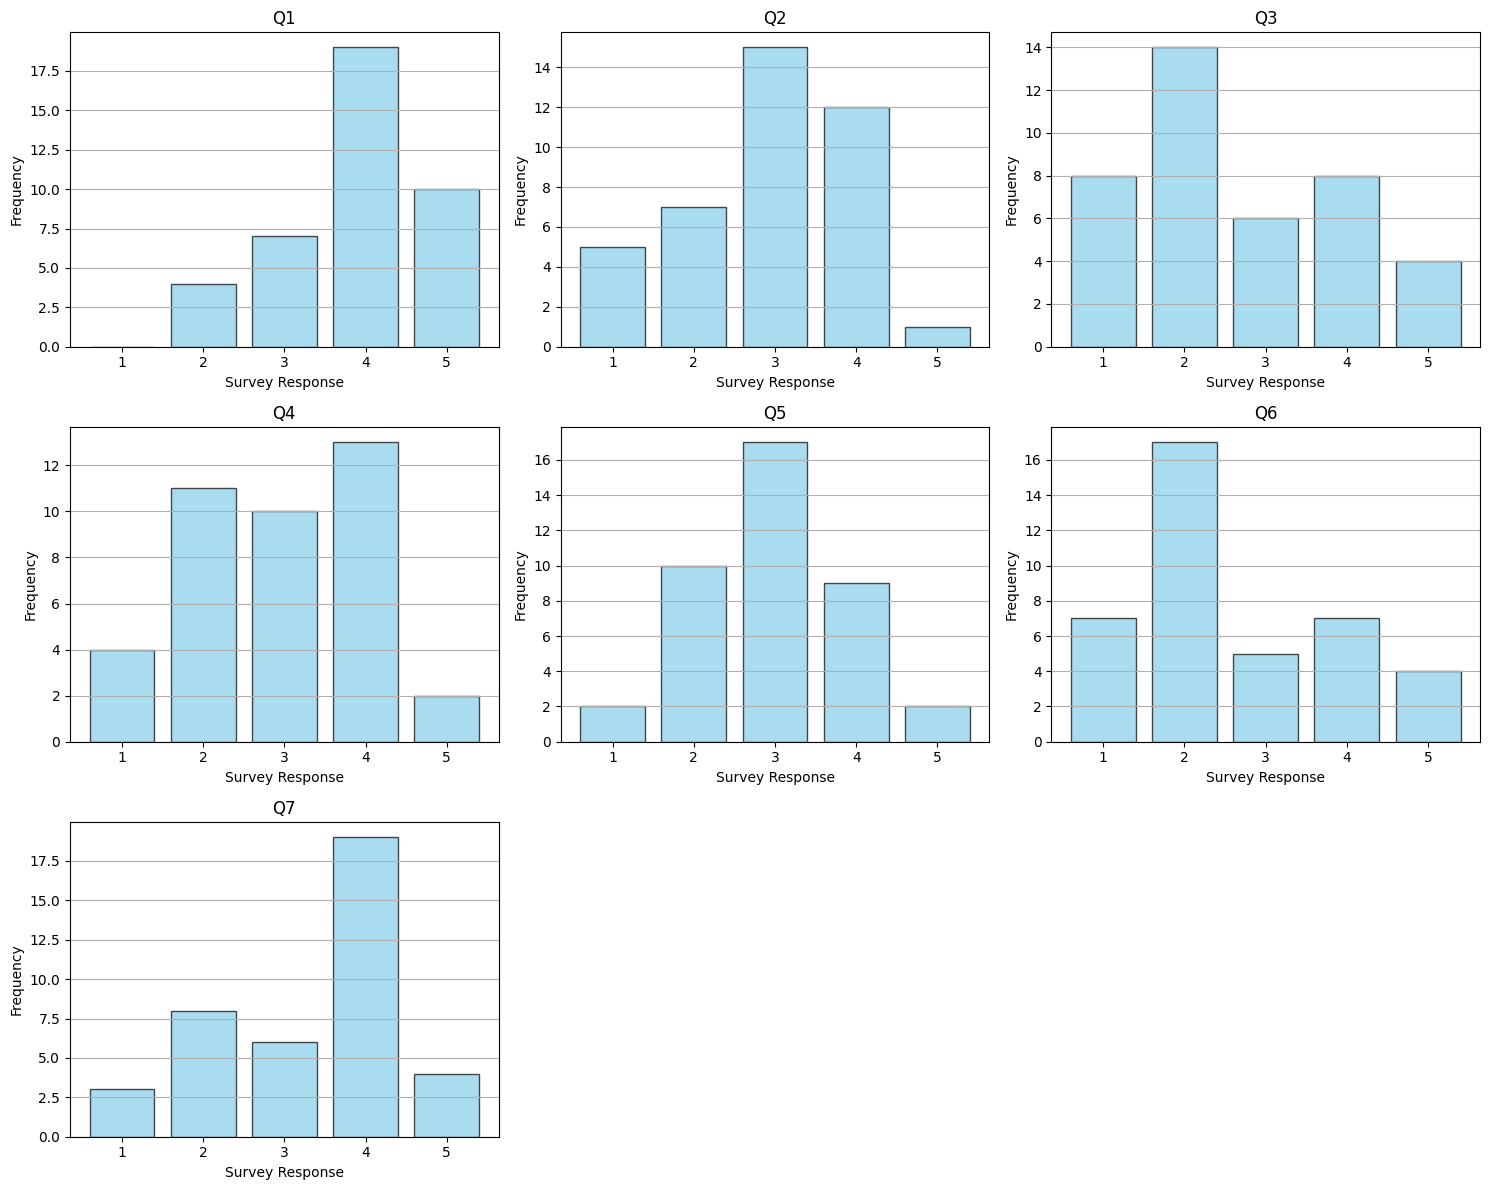

In [ ]:
frequency_of_responses_to_survey(question_list, survey_results)